In this notebook, we will do some plots to estimate redshift results for 4 methods below:
1. bliss redshift estimate directly from images 
2. redshift estimate based on LSST predicted mag and rail pipeline(FLEXZBOOST)
3. redshift estimate based on LSST predicted mag and neural network pretrained.
4. redshift estimate based on LSST predicted mag and neural network pretrained with filtering(filter out bad predicted position and flux points)

each method should have metrics vs galaxy fluxes, mse vs blendedness and mse vs true_redshifts

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import torch
from os import environ
from pathlib import Path
from einops import rearrange
import pickle
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from hydra import initialize, compose
from hydra.utils import instantiate

from pytorch_lightning.utilities import move_data_to_device

from bliss.catalog import FullCatalog, BaseTileCatalog, TileCatalog
from bliss.surveys.dc2 import DC2DataModule
from case_studies.redshift.evaluation.utils.load_lsst import get_lsst_full_cat
from case_studies.redshift.evaluation.utils.safe_metric_collection import SafeMetricCollection as MetricCollection
from case_studies.redshift.redshift_from_img.encoder.metrics import RedshiftMeanSquaredErrorBin

environ["BLISS_HOME"] = str(Path().resolve().parents[2])

output_dir = Path("/data/scratch/qiaozhih/DC2output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "/data/scratch/qiaozhih/DC2_redshift_training/DC2_redshift_only_bin_allmetrics/checkpoints/encoder_0.182845.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_plot")

In [4]:
# set up testing dataset
dataset = instantiate(notebook_cfg.train.data_source)
dataset.setup("test")


In [5]:
dataset.test_dataset

In [6]:
len(dataset.test_dataset)

25000

In [7]:
import os
os.environ['OMP_NUM_THREADS'] = '16'
os.environ['MKL_NUM_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '16'

# Create dc2 hdf5 data for rail training

In [8]:
import h5py
def create_output_file(outfile,xdf, start_rows, end_rows):
    outf = h5py.File(outfile,"w")
    xx = outf.create_group('photometry')
    for key in xdf.keys():
        print(key)
        if key != 'id':
            #outf.create_dataset(f'{key}', (num_rows,), dtype='f4')
            xx[f'{key}'] = xdf[key][start_rows: end_rows]
    outf.close()

In [9]:
save_path = "/data/scratch/qiaozhih/data/redshift/dc2/rail_train_lsst_2000k.hdf5"
if not os.path.exists(save_path):
    train_path = "/data/scratch/qiaozhih/data/redshift/dc2/desc_dc2_run2.2i_dr6_truth_nona_train.pkl"
    train_set = pd.read_pickle(train_path)
    train_set = train_set.rename({
        'mag_g':'mag_g_lsst', 'mag_i': 'mag_i_lsst', 'mag_r': 'mag_r_lsst', 'mag_u': 'mag_u_lsst', 'mag_y': 'mag_y_lsst', 'mag_z': 'mag_z_lsst'
    }, axis=1)
    names = ['magerr_g_lsst', 'magerr_i_lsst', 'magerr_r_lsst', 'magerr_u_lsst', 'magerr_y_lsst', 'magerr_z_lsst']
    for name in names:
        train_set[name] = 0
    create_output_file(save_path, train_set, 0, 2_000_000)


# Create lsst hdf5 data for rail testing

In [10]:
save_path = "/data/scratch/qiaozhih/data/redshift/dc2/test_objid_nona.pkl"
if os.path.exists(save_path):
    match_id = pd.read_pickle(save_path)
else:
    match_id = []
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        for ids in batch["objid"]:
            match_id += list(ids[ids != 0].tolist())

    match_id = pd.DataFrame({"objid": list(set(match_id))})
    match_id.objid = match_id.objid.replace(-1, np.nan).dropna()
    match_id.to_pickle(save_path)

In [11]:
# load lsst table and load mag_u, match_objectId
import GCRCatalogs
import pandas as pd
import torch

from bliss.catalog import FullCatalog, SourceType

# load lsst data
def get_lsst_catalog_df(lsst_root_dir: str):
    GCRCatalogs.set_root_dir(lsst_root_dir)
    lsst_catalog_gcr = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
    print(sorted(lsst_catalog_gcr.list_all_quantities()))
    lsst_catalog_sub = lsst_catalog_gcr.get_quantities(
        [
            "id_truth",
            "redshift_truth",
            "mag_u_cModel",
            "mag_g_cModel",
            "mag_r_cModel",
            "mag_i_cModel",
            "mag_z_cModel",
            "mag_y_cModel",
            "magerr_u_cModel",
            "magerr_g_cModel",
            "magerr_r_cModel",
            "magerr_i_cModel",
            "magerr_z_cModel",
            "magerr_y_cModel",
            "blendedness"
        ]
    )
    lsst_catalog_df = pd.DataFrame(lsst_catalog_sub)
    lsst_catalog_df = lsst_catalog_df.rename({
        "id_truth": "id",
        "redshift_truth": "redshift",
        "mag_u_cModel": "mag_u_lsst",
        "mag_g_cModel": "mag_g_lsst",
        "mag_r_cModel": "mag_r_lsst",
        "mag_i_cModel": "mag_i_lsst",
        "mag_z_cModel": "mag_z_lsst",
        "mag_y_cModel": "mag_y_lsst",
        "magerr_u_cModel": "magerr_u_lsst",
        "magerr_g_cModel": "magerr_g_lsst",
        "magerr_r_cModel": "magerr_r_lsst",
        "magerr_i_cModel": "magerr_i_lsst",
        "magerr_z_cModel": "magerr_z_lsst",
        "magerr_y_cModel": "magerr_y_lsst",
    }, axis=1)
    return lsst_catalog_df


In [12]:
save_path = "/data/scratch/qiaozhih/data/redshift/dc2/lsst_from_loader.pkl"

if os.path.exists(save_path):
    lsst_test_df_cleaned = pd.read_pickle(save_path)
else:
    lsst_root_dir = "/data/scratch/dc2_nfs/"
    lsst_df = get_lsst_catalog_df(lsst_root_dir)
    lsst_test_df = lsst_df.merge(match_id, left_on="id", right_on="objid", how="inner")
    blendedness_col = lsst_test_df['blendedness']
    lsst_test_df_cleaned = lsst_test_df.drop(columns=['blendedness'])
    lsst_test_df_cleaned = lsst_test_df_cleaned.replace([-np.inf, np.inf], np.nan).dropna()
    lsst_test_df_cleaned['blendedness'] = blendedness_col
    lsst_test_df_cleaned['blendedness'] = lsst_test_df_cleaned['blendedness'].clip(lower=0)
    lsst_test_df_cleaned.to_pickle(save_path)

In [13]:
lsst_test_df_cleaned

,magerr_r_lsst,magerr_i_lsst,mag_r_lsst,magerr_z_lsst,id,mag_i_lsst,redshift,mag_z_lsst,magerr_y_lsst,mag_y_lsst,magerr_u_lsst,mag_g_lsst,magerr_g_lsst,mag_u_lsst,objid,blendedness
0,0.172251,0.140670,26.553713,0.264937,7814051239,25.669444,0.839832,25.263065,0.395851,24.903307,1.212084,27.055722,0.235051,27.730753,7814051239,0.000000
2,0.012444,0.014196,23.086168,0.026528,7814629599,22.547220,0.967394,22.221716,0.047186,22.083597,0.034993,23.333075,0.013873,23.518119,7814629599,0.000000
4,0.026674,0.035848,24.153872,0.066202,7815280811,23.911637,1.089948,23.366286,0.104606,23.150045,0.078906,24.618163,0.030803,24.545713,7815280811,0.000000
5,0.035030,0.027286,24.699782,0.045534,7814650344,23.787722,0.967044,23.214039,0.095955,23.257274,0.255764,25.536230,0.066864,25.986805,7814650344,0.000000
7,0.101570,0.171899,25.606839,0.492072,7820962732,25.649606,1.887695,25.536967,0.551835,24.962034,0.182260,25.664907,0.082626,25.312179,7820962732,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216640,0.092505,0.188627,25.501252,0.557585,6826797195,25.713485,2.249122,25.713794,0.991205,25.778460,0.205814,25.558880,0.081979,25.492584,6826797195,0.001545
216641,0.230867,0.269445,26.725371,0.222855,6816190654,26.287236,1.225945,24.925124,0.374261,24.783601,1.501178,27.368953,0.331299,27.881458,6816190654,0.052134
216642,0.136375,0.492015,26.293036,2.035231,6817006604,27.095743,1.361237,27.464616,0.483658,25.153565,0.249105,26.430428,0.131411,25.989243,6817006604,0.003181
216643,0.125411,0.167018,25.771009,0.193352,6815328103,25.296727,1.088457,24.472974,3.219299,26.912059,0.438057,26.023054,0.154876,26.153959,6815328103,0.063560


In [14]:
save_path = "/data/scratch/qiaozhih/data/redshift/dc2/rail_test_lsst.hdf5"
if not os.path.exists(save_path):
    create_output_file(save_path, lsst_test_df_cleaned, 0, -1)

so now, we can use rail_train_lsst.hdf and rail_test_lsst.hdf5 to train/test rail pipeline. You might need to setup rail pipeline following \
https://rail-hub.readthedocs.io/en/latest/source/installation.html. 

I am using flexzboost pipeline to do training and testing. 

# Next, we will do data/metrics preparation for plotting

### 1. lsst+neural network without filter

The neural network used is pretrained using network of /home/qiaozhih/bliss/case_studies/redshift/network_rs.py. For reproduction, run /home/qiaozhih/bliss/case_studies/redshift/train.sh

In [15]:
from case_studies.redshift.network_rs import PhotoZFromMag
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn
num_bins = 1
group_size = 128
batch_size = 1
in_dim = 6
device = "cuda"
path = "/data/scratch/qiaozhih/training_runs/00120-run/tensorboard_logs/version_0/checkpoints/reg_val_loss=0.000367_epoch=29.ckpt"
network_options = {
    "hidden_dim": 256,
    "out_dim": num_bins,
    "n_epochs": 50001,
    "outdir": "/home/qiaozhih/bliss/case_studies/redshift/training_runs/",
    "snap": 1,  # how many epoches to save one model once
    "loss_fcn": torch.nn.MSELoss(),  # loss func
    # 'loss_fcn': torch.nn.CrossEntropyLoss(),                     # loss func
    "dropout_rate": 0.5,
    "learning_rate": 1e-3,
    "group_size": group_size,
    "num_gpu": 1,
    "gpu_device": [0],
}

reg = PhotoZFromMag.load_from_checkpoint(
    path,
    in_dim=in_dim,
    hidden_dim=network_options["hidden_dim"],
    out_dim=network_options["out_dim"],
    dropout_rate=network_options["dropout_rate"],
    learning_rate=network_options["learning_rate"],
    loss_fcn=network_options["loss_fcn"],
)
reg.to(device)
reg.eval()

PhotoZFromMag(
  (loss_fcn): MSELoss()
  (net): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [16]:
mag_lsst = torch.from_numpy(lsst_test_df_cleaned[["mag_u_lsst", "mag_g_lsst", "mag_r_lsst", "mag_i_lsst", "mag_z_lsst", "mag_y_lsst"]].values).to(torch.float32).to(device)
pred_rs = reg.net(mag_lsst)
pred_rs = pred_rs.detach().to('cpu')

lsst_df = pd.DataFrame({
    "true_red": lsst_test_df_cleaned['redshift'],
    "est_red": pred_rs.squeeze(-1),
    "mag_r": lsst_test_df_cleaned['mag_r_lsst'],
    "id": lsst_test_df_cleaned['objid'],
    "blendedness": lsst_test_df_cleaned['blendedness'],
})

In [17]:
mag_bins = [-np.inf, 23.9, 24.1, 24.5, 24.9, 25.6, np.inf]
mag_labels = ["<23.9", "23.9-24.1", "24.1-24.5", "24.5-24.9", "24.9-25.6", ">25.6"]
true_red_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, np.inf]
true_red_labels = ["<0.5", "0.5-1.0", "1.0-1.5", "1.5-2.0", "2.0-2.5", "2.5-3.0",">3.0"]
blendedness_bins = [-np.inf ,0.0001, 0.02, 0.1, 0.2, 0.6, np.inf]
blendedness_labels = ["<0.0001", "0.0001-0.02", "0.02-0.1", "0.1-0.2", "0.2-0.6",">0.6"]
lsst_df['mag_bins'] = pd.cut(lsst_df['mag_r'], bins=mag_bins, labels=mag_labels, include_lowest=True)
lsst_df['true_red_bins'] = pd.cut(lsst_df['true_red'], bins=true_red_bins, labels=true_red_labels, include_lowest=True)
lsst_df['blendedness_bins'] = pd.cut(lsst_df['blendedness'], bins=blendedness_bins, labels=blendedness_labels, include_lowest=True)

def calculate_mse(group):
    return ((group['true_red'] - group['est_red']) ** 2).mean()

def calculate_outlier_fraction(group):
    metric_outlier = np.abs(group['true_red'] - group['est_red']) / (1 + group['true_red'])
    num_outlier = (metric_outlier > 0.15).sum()
    return num_outlier / len(metric_outlier)

def calculate_outlier_fraction_cata(group):
    metric_outlier = np.abs(group['true_red'] - group['est_red']) / (1 + group['true_red'])
    num_outlier = (metric_outlier > 1).sum()
    return num_outlier / len(metric_outlier)

def calculate_nmad(group):
    metric = (group['true_red'] - group['est_red']) / (1 + group['true_red'])
    bias = np.median(metric)
    nmad_all = np.abs(metric - bias)
    nmad = 1.4826 * np.median(nmad_all)
    return nmad

def calculate_bias_abs(group):
    metric = np.abs(group['true_red'] - group['est_red']) / (1 + group['true_red'])
    return np.median(metric)

In [18]:
out_dir = "/data/scratch/qiaozhih/data/redshift/metrics_result"
os.makedirs(out_dir, exist_ok=True)

In [19]:
# mag
save_path = os.path.join(out_dir, "lsst_nn_metrics_mag.csv")
if os.path.exists(save_path):
    metrics_df_stratified_by_mag = pd.read_csv(save_path, index_col=0)
else:
    mse_by_mag_range = lsst_df.groupby('mag_bins').apply(calculate_mse).reset_index(name='mse')
    outlier_fraction_by_mag_range = lsst_df.groupby('mag_bins').apply(calculate_outlier_fraction).reset_index(name='outlier_fraction')
    outlier_fraction_cata_by_mag_range = lsst_df.groupby('mag_bins').apply(calculate_outlier_fraction_cata).reset_index(name='outlier_fraction')
    nmad_by_mag_range = lsst_df.groupby('mag_bins').apply(calculate_nmad).reset_index(name='nmad')
    bias_abs_by_mag_range = lsst_df.groupby('mag_bins').apply(calculate_bias_abs).reset_index(name='bias_abs')
    merged_df = mse_by_mag_range.merge(outlier_fraction_by_mag_range, on='mag_bins')
    merged_df = merged_df.merge(outlier_fraction_cata_by_mag_range, on='mag_bins', suffixes=('', '_cata'))
    merged_df = merged_df.merge(nmad_by_mag_range, on='mag_bins')
    metrics_df_stratified_by_mag = merged_df.merge(bias_abs_by_mag_range, on='mag_bins')
    metrics_df_stratified_by_mag.to_csv(save_path)

In [20]:
# true red
save_path = os.path.join(out_dir, "lsst_nn_metrics_truered.csv")
if not os.path.exists(save_path):
    mse_by_true_red_range = lsst_df.groupby('true_red_bins').apply(calculate_mse).reset_index(name='mse')
    mse_by_true_red_range.to_csv(save_path)
else:
    mse_by_true_red_range = lsst_df

In [21]:
# blendedness
save_path = os.path.join(out_dir, "lsst_nn_metrics_blendedness.csv")
if os.path.exists(save_path):
    mse_by_blendedness_range = pd.read_csv(save_path, index_col=0)
else:
    mse_by_blendedness_range = lsst_df.groupby('blendedness_bins').apply(calculate_mse).reset_index(name='mse')
    mse_by_blendedness_range.to_csv(save_path)

In [22]:
metrics_df_stratified_by_mag

,mag_bins,mse,outlier_fraction,outlier_fraction_cata,nmad,bias_abs
0,<23.9,0.103721,0.131896,0.010469,0.040274,0.027244
1,23.9-24.1,0.233934,0.235642,0.029899,0.074874,0.050983
2,24.1-24.5,0.283330,0.251014,0.033927,0.080964,0.054483
3,24.5-24.9,0.339445,0.307011,0.035431,0.105267,0.070991
4,24.9-25.6,0.499141,0.419653,0.036058,0.166284,0.112938
5,>25.6,0.763448,0.575723,0.025460,0.277294,0.189871


In [23]:
mse_by_true_red_range

,true_red,est_red,mag_r,id,blendedness,mag_bins,true_red_bins,blendedness_bins
0,0.839832,1.066343,26.553713,7814051239,0.000000,>25.6,0.5-1.0,<0.0001
2,0.967394,0.794271,23.086168,7814629599,0.000000,<23.9,0.5-1.0,<0.0001
4,1.089948,0.982657,24.153872,7815280811,0.000000,24.1-24.5,1.0-1.5,<0.0001
5,0.967044,0.820597,24.699782,7814650344,0.000000,24.5-24.9,0.5-1.0,<0.0001
7,1.887695,1.269331,25.606839,7820962732,0.000000,>25.6,1.5-2.0,<0.0001
...,...,...,...,...,...,...,...,...
216640,2.249122,1.416525,25.501252,6826797195,0.001545,24.9-25.6,2.0-2.5,0.0001-0.02
216641,1.225945,1.140823,26.725371,6816190654,0.052134,>25.6,1.0-1.5,0.02-0.1
216642,1.361237,1.260050,26.293036,6817006604,0.003181,>25.6,1.0-1.5,0.0001-0.02
216643,1.088457,0.690057,25.771009,6815328103,0.063560,>25.6,1.0-1.5,0.02-0.1


In [24]:
mse_by_blendedness_range

,blendedness_bins,mse
0,<0.0001,0.533766
1,0.0001-0.02,0.450912
2,0.02-0.1,0.644703
3,0.1-0.2,0.664023
4,0.2-0.6,0.603926
5,>0.6,0.636051


so now we got table for lsst + neural network, which can be used for later plot.

### 2. bliss redshift estimate directly from images

In [25]:
# Loop through the test set and update the metric
# load bliss trained model
bliss_encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder.eval();

In [26]:
bliss_output_path = output_dir / "bliss_output_large_split.pkl"

if not bliss_output_path.exists():
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        batch["images"] = batch["images"].to(device)
        bliss_encoder.update_metrics(batch, batch_idx)
    bliss_out_dict = bliss_encoder.mode_metrics.compute()

    with open(bliss_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(bliss_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(bliss_output_path, "rb") as inputp:
        bliss_out_dict = pickle.load(inputp)

In [27]:
from case_studies.redshift.network_rs import PhotoZFromMag
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn
num_bins = 1
group_size = 128
batch_size = 1
in_dim = 6
device = "cuda"
path = "/data/scratch/qiaozhih/training_runs/00120-run/tensorboard_logs/version_0/checkpoints/reg_val_loss=0.000367_epoch=29.ckpt"
network_options = {
    "hidden_dim": 256,
    "out_dim": num_bins,
    "n_epochs": 50001,
    "outdir": "/home/qiaozhih/bliss/case_studies/redshift/training_runs/",
    "snap": 1,  # how many epoches to save one model once
    "loss_fcn": torch.nn.MSELoss(),  # loss func
    # 'loss_fcn': torch.nn.CrossEntropyLoss(),                     # loss func
    "dropout_rate": 0.5,
    "learning_rate": 1e-3,
    "group_size": group_size,
    "num_gpu": 1,
    "gpu_device": [0],
}

reg = PhotoZFromMag.load_from_checkpoint(
    path,
    in_dim=in_dim,
    hidden_dim=network_options["hidden_dim"],
    out_dim=network_options["out_dim"],
    dropout_rate=network_options["dropout_rate"],
    learning_rate=network_options["learning_rate"],
    loss_fcn=network_options["loss_fcn"],
)
reg.to(device)
reg.eval()

PhotoZFromMag(
  (loss_fcn): MSELoss()
  (net): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [28]:
def est_redshifts_with_reg_change_to_cat(cat: TileCatalog, reg: PhotoZFromMag, tile_slen: int, min_flux_for_loss: int=50, reference_band: int=2) -> BaseTileCatalog | FullCatalog:
    """estimate redshift by inputting true mag using regressor, then convert them to Basetilecatalog

    Args:
        cat: catalog
        reg: regressor that accept ugrizy mag

    Returns:
        Catalog that containing pred redshifts
    """
    cat = cat.filter_by_flux(
        min_flux=min_flux_for_loss,
        band=reference_band,
    )
    mag = cat.on_fluxes("njymag")

    new_order = [3, 0, 2, 1, 5, 4] # change giruyz to ugrizy
    mag = mag[..., new_order]
    is_galaxy = cat.galaxy_bools.to(device)
    N, H, W, M, _ = mag.shape
    mag = mag.reshape(-1, 6)
    is_galaxy = is_galaxy.reshape(-1, 1)
    pred_rs = torch.zeros_like(mag[..., 0])
    for i in range(len(mag)):
        if is_galaxy[i][0]: 
            x = mag[i].unsqueeze(0).to(device) # 1, 6
            pred_rs[i] = reg.net(x).squeeze(0)
    pred_rs = pred_rs.to('cpu')
    pred_rs = {"redshifts": pred_rs.reshape((N, H, W, M, 1))}

    cat["redshifts"] = pred_rs["redshifts"]
    return cat

### 3. redshift estimate based on LSST predicted flux + neural network with filtering

In [29]:
import GCRCatalogs
import pandas as pd
import torch

from bliss.catalog import FullCatalog, SourceType

# load lsst data
def get_lsst_catalog_tensors_dict(lsst_root_dir: str):
    GCRCatalogs.set_root_dir(lsst_root_dir)
    lsst_catalog_gcr = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
    lsst_catalog_sub = lsst_catalog_gcr.get_quantities(
        [
            "id_truth",
            "objectId",
            "ra",
            "dec",
            "truth_type",
            "cModelFlux_u",
            "cModelFluxErr_u",
            "cModelFlux_g",
            "cModelFluxErr_g",
            "cModelFlux_r",
            "cModelFluxErr_r",
            "cModelFlux_i",
            "cModelFluxErr_i",
            "cModelFlux_z",
            "cModelFluxErr_z",
            "cModelFlux_y",
            "cModelFluxErr_y",
        ]
    )
    lsst_catalog_df = pd.DataFrame(lsst_catalog_sub)
    lsst_flux_lst = [
        lsst_catalog_df["cModelFlux_g"],
        lsst_catalog_df["cModelFlux_i"],
        lsst_catalog_df["cModelFlux_r"],
        lsst_catalog_df["cModelFlux_u"],
        lsst_catalog_df["cModelFlux_y"],
        lsst_catalog_df["cModelFlux_z"],
    ]
    lsst_flux_tensors_lst = [torch.tensor(flux.values).view(-1, 1) for flux in lsst_flux_lst]
    return {
        "truth_type": torch.tensor(lsst_catalog_df["truth_type"].values).view(-1, 1),
        "flux": torch.cat(lsst_flux_tensors_lst, dim=1),
        "ra": torch.tensor(lsst_catalog_df["ra"].values),
        "dec": torch.tensor(lsst_catalog_df["dec"].values),
    }
    
def get_lsst_catalog_tensors_dict(lsst_root_dir: str):
    GCRCatalogs.set_root_dir(lsst_root_dir)
    lsst_catalog_gcr = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
    lsst_catalog_sub = lsst_catalog_gcr.get_quantities(
        [
            "id_truth",
            "objectId",
            "ra",
            "dec",
            "truth_type",
            "cModelFlux_u",
            "cModelFluxErr_u",
            "cModelFlux_g",
            "cModelFluxErr_g",
            "cModelFlux_r",
            "cModelFluxErr_r",
            "cModelFlux_i",
            "cModelFluxErr_i",
            "cModelFlux_z",
            "cModelFluxErr_z",
            "cModelFlux_y",
            "cModelFluxErr_y",
        ]
    )
    lsst_catalog_df = pd.DataFrame(lsst_catalog_sub)
    lsst_flux_lst = [
        lsst_catalog_df["cModelFlux_g"],
        lsst_catalog_df["cModelFlux_i"],
        lsst_catalog_df["cModelFlux_r"],
        lsst_catalog_df["cModelFlux_u"],
        lsst_catalog_df["cModelFlux_y"],
        lsst_catalog_df["cModelFlux_z"],
    ]
    lsst_flux_tensors_lst = [torch.tensor(flux.values).view(-1, 1) for flux in lsst_flux_lst]
    return {
        "truth_type": torch.tensor(lsst_catalog_df["truth_type"].values).view(-1, 1),
        "flux": torch.cat(lsst_flux_tensors_lst, dim=1),
        "ra": torch.tensor(lsst_catalog_df["ra"].values),
        "dec": torch.tensor(lsst_catalog_df["dec"].values),
    }
import torch

from bliss.catalog import FullCatalog, SourceType, TileCatalog
from bliss.surveys.dc2 import wcs_from_wcs_header_str

def concatenate_tile_dicts(tile_dict_list):
    output_tile_cat_dict = {}
    for k in tile_dict_list[0].keys():
        if k not in output_tile_cat_dict:
            output_tile_cat_dict[k] = []
        for tile_dict in tile_dict_list:
            output_tile_cat_dict[k].append(tile_dict[k])

    for k, v in output_tile_cat_dict.items():
        output_tile_cat_dict[k] = torch.cat(v, dim=0)

    return output_tile_cat_dict


class LSSTPredictor:
    def __init__(
        self, lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile, tiles_to_crop
    ) -> None:
        self.lsst_data = get_lsst_catalog_tensors_dict(lsst_root_dir)
        self.r_band_min_flux = r_band_min_flux
        self.tile_slen = tile_slen
        self.max_sources_per_tile = max_sources_per_tile
        self.tiles_to_crop = tiles_to_crop

        self.buffered_wcs_header_str = None
        self.buffered_lsst_plocs = None

    def _predict_one_image(self, wcs_header_str, image_lim, height_index, width_index):
        if wcs_header_str != self.buffered_wcs_header_str:
            lsst_ra = self.lsst_data["ra"]
            lsst_dec = self.lsst_data["dec"]
            cur_image_wcs = wcs_from_wcs_header_str(wcs_header_str)
            lsst_plocs = FullCatalog.plocs_from_ra_dec(lsst_ra, lsst_dec, cur_image_wcs)
            self.buffered_wcs_header_str = wcs_header_str
            self.buffered_lsst_plocs = lsst_plocs
        else:
            lsst_plocs = self.buffered_lsst_plocs
    
        lsst_source_type = self.lsst_data["truth_type"]
        lsst_flux = self.lsst_data["flux"]

        x0_mask = (lsst_plocs[:, 0] > height_index * image_lim) & (
            lsst_plocs[:, 0] < (height_index + 1) * image_lim
        )
        x1_mask = (lsst_plocs[:, 1] > width_index * image_lim) & (
            lsst_plocs[:, 1] < (width_index + 1) * image_lim
        )
        lsst_x_mask = x0_mask * x1_mask
        # filter r band
        filter_band = ["g", "i", "r", "u", "y", "z"]
        for i in range(len(filter_band)):
            lsst_flux_mask = (lsst_flux[:, i] > self.r_band_min_flux) & (lsst_flux[:, i] < torch.inf)
            lsst_x_mask = lsst_x_mask * lsst_flux_mask

        lsst_mask = lsst_x_mask
        lsst_plocs = lsst_plocs[lsst_mask, :] % image_lim
        lsst_source_type = torch.where(
            lsst_source_type[lsst_mask] == SourceType.STAR, SourceType.STAR, SourceType.GALAXY
        )
        lsst_flux = lsst_flux[lsst_mask, :]
        lsst_n_sources = torch.tensor([lsst_plocs.shape[0]])

        return FullCatalog(
            height=image_lim,
            width=image_lim,
            d={
                "plocs": lsst_plocs.unsqueeze(0),
                "n_sources": lsst_n_sources,
                "source_type": lsst_source_type.unsqueeze(0),
                "galaxy_fluxes": lsst_flux.unsqueeze(0),
                "star_fluxes": lsst_flux.unsqueeze(0).clone(),
            },
        ).to_tile_catalog(self.tile_slen, self.max_sources_per_tile, ignore_extra_sources=True)

    def predict(self, wcs_header_str_list, image_lim, height_index_list, width_index_list):
        assert len(wcs_header_str_list) == len(height_index_list), "unequal input list size"
        assert len(wcs_header_str_list) == len(width_index_list), "unequal input list size"
        tile_dict_list = []
        predict_input_data = zip(wcs_header_str_list, height_index_list, width_index_list)
        for wcs_header_str, height_index, width_index in predict_input_data:
            tile_dict_list.append(
                self._predict_one_image(wcs_header_str, image_lim, height_index, width_index).data
            )

        merged_tile_dict = concatenate_tile_dicts(tile_dict_list)
        return TileCatalog(merged_tile_dict)

In [30]:
from bliss.encoder.metrics import CatalogMatcher
lsst_output_path = output_dir / "lsst_output_large_split_final.pkl"
mag_dist_path = output_dir / "lsst_mag_dist_large_split_final.pkl"
blendedness_dist_path = output_dir / "lsst_blendedness_dist_large_split_final.pkl"
true_redshift_dist_path = output_dir / "lsst_true_redshift_dist_large_split_final.pkl"
    
if not lsst_output_path.exists() or not mag_dist_path.exists():
    metrics = instantiate(notebook_cfg.encoder.mode_metrics)
    matcher = CatalogMatcher()

    metrics.reset()
    # args
    lsst_root_dir = "/data/scratch/dc2_nfs/"
    image_lim = 80
    r_band_min_flux = 50
    tile_slen = 4
    max_sources_per_tile = 1
    max_batch = -1
    tiles_to_crop = 1

    lsst_predictor = LSSTPredictor(lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile, tiles_to_crop)
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        true_cat = TileCatalog(d=batch["tile_catalog"]).get_brightest_sources_per_tile()
        lsst_cat = lsst_predictor.predict(batch["wcs_header_str"], image_lim, batch["image_height_index"], batch["image_width_index"])
        est_cat = est_redshifts_with_reg_change_to_cat(lsst_cat, reg, tile_slen=4)
        est_cat = est_cat.to_full_catalog(tile_slen=4)
        true_cat = true_cat.to_full_catalog(tile_slen=4)
        matching = matcher.match_catalogs(true_cat, est_cat)
        metrics.update(true_cat, est_cat, matching)
        if not (batch_idx < max_batch or max_batch < 0):
            break

    lsst_out_dict = metrics.compute()
    # num_bins = metrics.RedshiftMeanSquaredErrorBin.total.numpy()
    num_blendedness = metrics["redshift_mean_square_error_blendedness"].total.numpy()
    num_redshifts = metrics["redshift_mean_square_error_true_redshifts"].total.numpy()

    with open(blendedness_dist_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(num_blendedness, outp, pickle.HIGHEST_PROTOCOL)    
    with open(true_redshift_dist_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(num_redshifts, outp, pickle.HIGHEST_PROTOCOL)
    with open(lsst_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(lsst_out_dict, outp, pickle.HIGHEST_PROTOCOL)
    with open(mag_dist_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(num_bins, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(lsst_output_path, "rb") as inputp:
        lsst_out_dict = pickle.load(inputp)
    with open(mag_dist_path, "rb") as inputp: 
        num_bins = pickle.load(inputp)
    with open(blendedness_dist_path, "rb") as inputp:  # Overwrites any existing file.
        num_blendedness = pickle.load(inputp)
    with open(true_redshift_dist_path, "rb") as inputp:
        num_redshifts = pickle.load(inputp)

### num of observation for mag

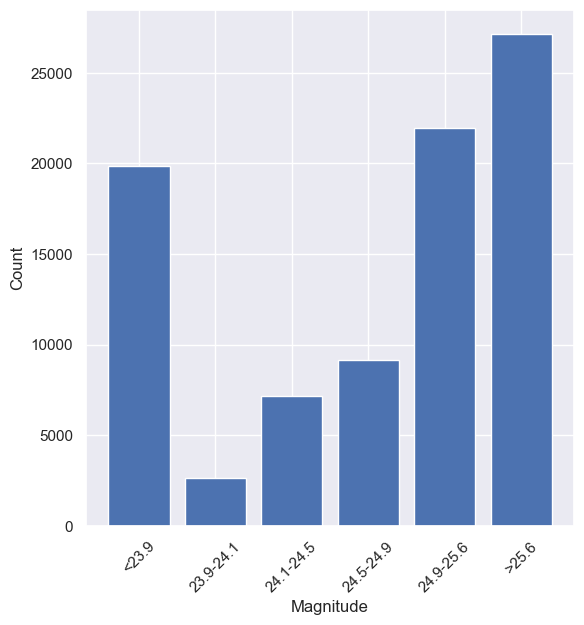

In [31]:
sns.set_theme()
mag_ranges = ['<23.9', '23.9-24.1', '24.1-24.5', '24.5-24.9', '24.9-25.6', '>25.6']
plt.figure(figsize=(6, 6))
plt.bar(mag_ranges, num_bins)
plt.xlabel("Magnitude")
plt.ylabel("Count")
# plt.legend(loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig(os.path.join("/home/qiaozhih/bliss/case_studies/redshift/evaluation/plot",f'dist_mag_lsst.pdf'), bbox_inches='tight')

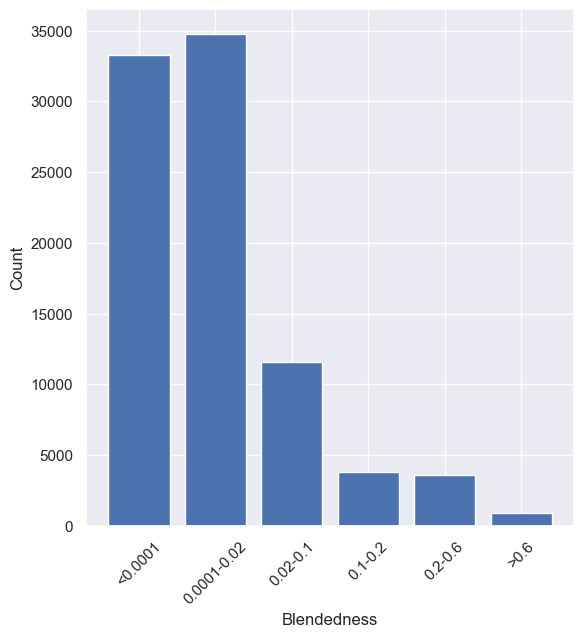

In [32]:
blendedness_ranges = ['<0.0001', '0.0001-0.02', '0.02-0.1', '0.1-0.2', '0.2-0.6', '>0.6']
plt.figure(figsize=(6, 6))
plt.bar(blendedness_ranges, num_blendedness)
plt.xlabel("Blendedness")
plt.ylabel("Count")
# plt.legend(loc='upper left')
plt.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig(os.path.join("/home/qiaozhih/bliss/case_studies/redshift/evaluation/plot",f'dist_blendedness_lsst.pdf'), bbox_inches='tight')

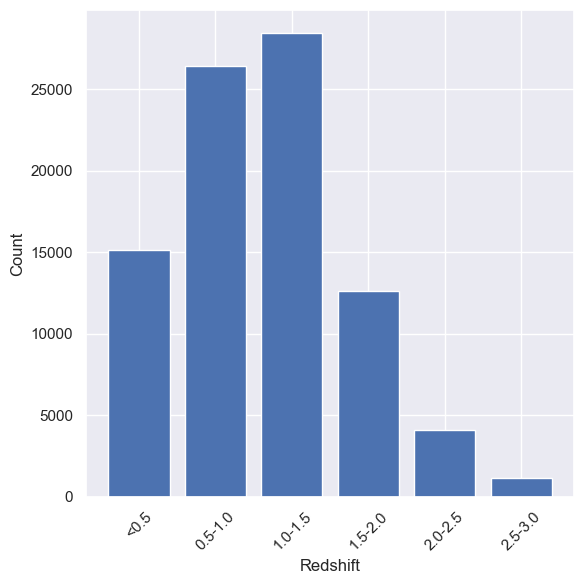

In [33]:
redshift_ranges = ['<0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0-2.5', '2.5-3.0']
plt.figure(figsize=(6, 6))
plt.bar(redshift_ranges, num_redshifts[: -1])
plt.xlabel("Redshift")
plt.ylabel("Count")
# plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join("/home/qiaozhih/bliss/case_studies/redshift/evaluation/plot",f'dist_redshift_lsst_no3.0.pdf'), bbox_inches='tight')

### 4.LSST + flexzboost

All this .csv file is generated using rail pipeline. Since rail is based on other env, we can't generate them on this notebook. Just use generated table for simplicity. 
For reproduction, you can check /home/qiaozhih/bliss/case_studies/redshift/evaluation/rail/RAIL_estimation_demo.ipynb. Make sure you are using rail's env

In [34]:
lsst_path = "/data/scratch/qiaozhih/data/redshift/metrics_result/lsst_flexzboost_metrics_mag.csv"
lsst_flexzboost_df = pd.read_csv(lsst_path, index_col=0)

# Make plots for all method

### 1.plot all metrics stratified by mag

In [35]:
lsst_path = "/data/scratch/qiaozhih/data/redshift/metrics_result/lsst_nn_metrics_mag.csv"
lsst_nn_df = pd.read_csv(lsst_path, index_col=0)

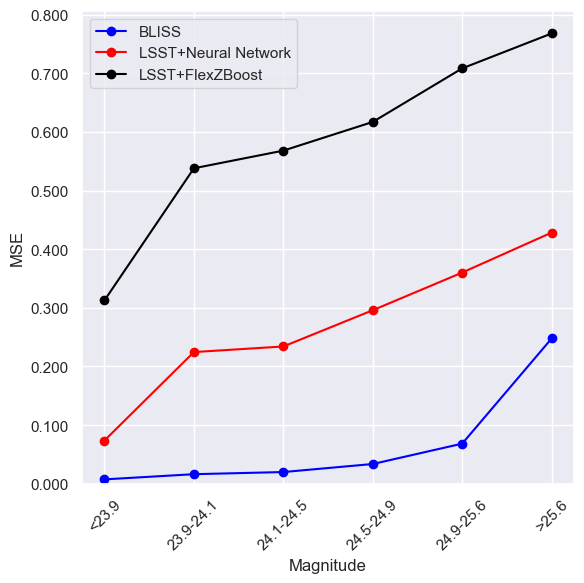

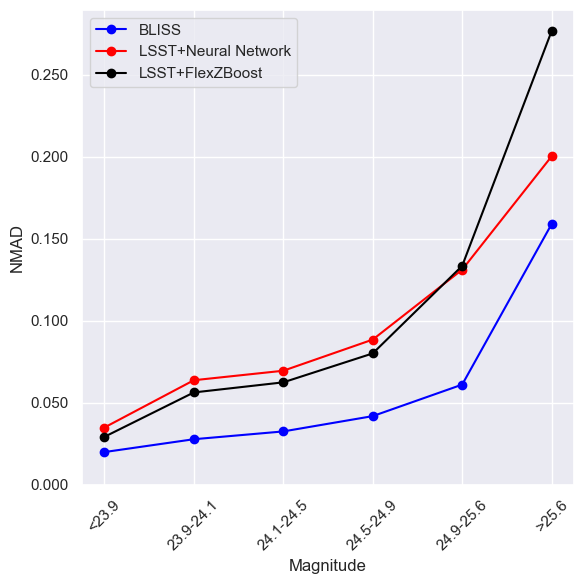

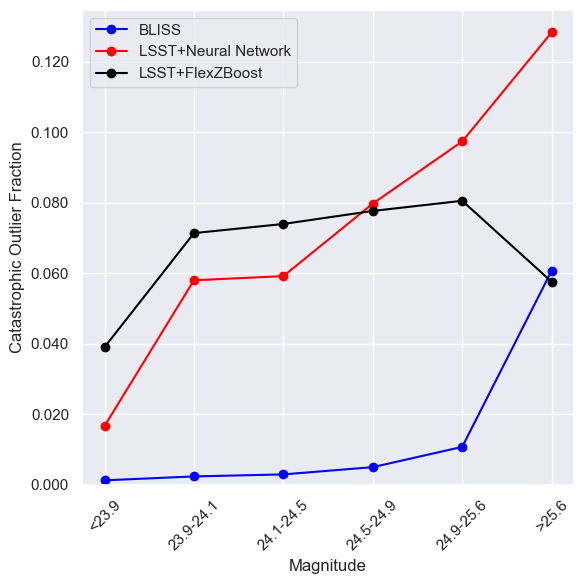

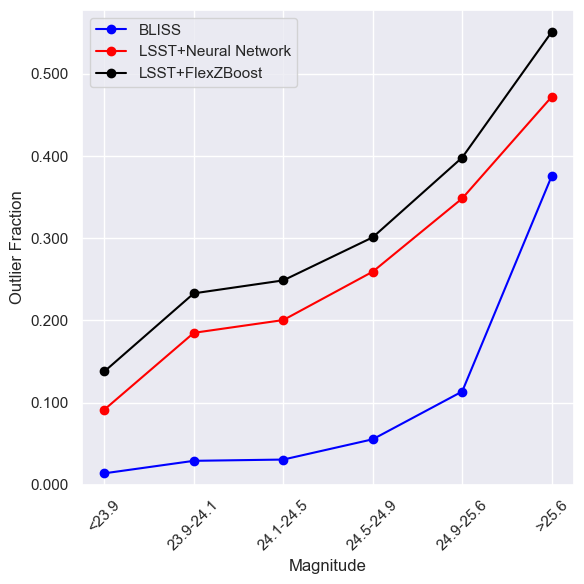

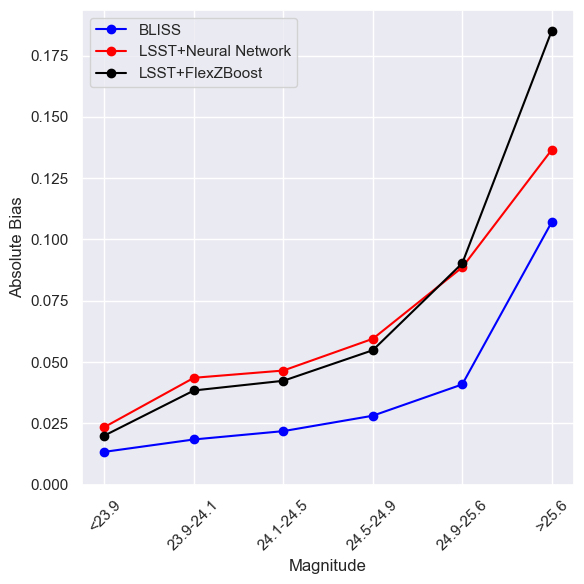

In [36]:
from matplotlib.ticker import FormatStrFormatter
metrics = ['mse', 'nmad', 'outlier_fraction_cata', 'outlier_fraction', 'bias_abs']
metric_labels = ['MSE', 'NMAD', 'Catastrophic Outlier Fraction', 'Outlier Fraction', 'Absolute Bias']
sns.set_theme()
for i, metric in enumerate(metrics):
    mag_ranges = lsst_flexzboost_df.mag_bins.values
    bliss_values = [bliss_out_dict[f'redshifts/{metric}_bin_{i}'] for i in reversed(range(6))]
    lsst_values = [lsst_out_dict[f'redshifts/{metric}_bin_{i}'] for i in range(6)]
    lsst_flexzboost_values = lsst_flexzboost_df[metric].values
    lsst_nn_values = lsst_nn_df[metric].values

    plt.figure(figsize=(6, 6))
    plt.plot(mag_ranges, bliss_values, label="BLISS", marker='o', c="blue")
    plt.plot(mag_ranges, lsst_values, label="LSST+Neural Network", marker='o', c="red")
    # plt.plot(mag_ranges, lsst_nn_values, label="lsst+neural network", marker='o', c="purple")
    plt.plot(mag_ranges, lsst_flexzboost_values, label="LSST+FlexZBoost", marker='o', c="black")
    plt.xlabel('Magnitude')
    plt.xticks(rotation=45)
    plt.ylabel(metric_labels[i])
    plt.ylim([0, None])
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.savefig(os.path.join("/home/qiaozhih/bliss/case_studies/redshift/evaluation/plot",f'3_line_per_mag_range_{metric}.pdf'))
    # plt.close()

### 2.Plot stratified by true redsfhits

In [37]:
from bliss.encoder.metrics import CatalogMatcher
# lsst_output_path = output_dir / "lsst_output_large_split_redshift.pkl"
lsst_output_path = output_dir / "lsst_output_large_split_final.pkl"
if not lsst_output_path.exists():
    metrics = instantiate(notebook_cfg.encoder.mode_metrics)
    matcher = CatalogMatcher()

    metrics.reset()
    # args
    lsst_root_dir = "/data/scratch/dc2_nfs/"
    image_lim = 80
    r_band_min_flux = 50
    tile_slen = 4
    max_sources_per_tile = 1
    max_batch = 300

    lsst_predictor = LSSTPredictor(lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile)
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        true_cat = TileCatalog(d=batch["tile_catalog"]).get_brightest_sources_per_tile()
        lsst_cat = lsst_predictor.predict(batch["wcs_header_str"], image_lim, batch["image_height_index"], batch["image_width_index"])
        est_cat = est_redshifts_with_reg_change_to_cat(lsst_cat, reg, tile_slen=4)
        est_cat = est_cat.to_full_catalog(tile_slen=4)
        true_cat = true_cat.to_full_catalog(tile_slen=4)
        matching = matcher.match_catalogs(true_cat, est_cat)
        metrics.update(true_cat, est_cat, matching)
        if not (batch_idx < max_batch or max_batch < 0):
            break

    lsst_out_dict = metrics.compute()

    with open(lsst_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(lsst_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(lsst_output_path, "rb") as inputp:
        lsst_out_dict = pickle.load(inputp)

In [38]:
bliss_output_path = output_dir / "bliss_output_large_split_redshift.pkl"

if not bliss_output_path.exists():
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        batch["images"] = batch["images"].to(device)
        bliss_encoder.update_metrics(batch, batch_idx)
    bliss_out_dict = bliss_encoder.mode_metrics.compute()

    with open(bliss_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(bliss_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(bliss_output_path, "rb") as inputp:
        bliss_out_dict = pickle.load(inputp)

In [39]:
lsst_path = "/data/scratch/qiaozhih/data/redshift/metrics_result/lsst_flexzboost_metrics_truered.csv"
lsst_flexzboost_df = pd.read_csv(lsst_path, index_col=0)

In [40]:
bliss_out_dict

{'redshifts/mse_redshifts_bin_0': 0.21011626720428467,
 'redshifts/mse_redshifts_bin_1': 0.04223083332180977,
 'redshifts/mse_redshifts_bin_2': 0.05187731236219406,
 'redshifts/mse_redshifts_bin_3': 0.07855614274740219,
 'redshifts/mse_redshifts_bin_4': 0.2421521693468094,
 'redshifts/mse_redshifts_bin_5': 0.9081681966781616,
 'redshifts/mse_redshifts_bin_6': 1.9326175451278687}

In [41]:
lsst_path = "/data/scratch/qiaozhih/data/redshift/metrics_result/lsst_nn_metrics_truered.csv"
lsst_nn_df = pd.read_csv(lsst_path, index_col=0)

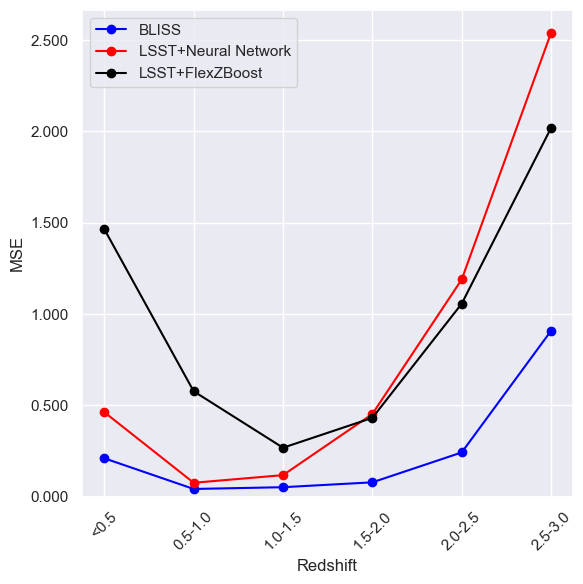

In [42]:
metrics = ['mse_redshifts_bin']
metric_labels = ['MSE']
sns.set_theme()
for i, metric in enumerate(metrics):
    redshifts_ranges = lsst_flexzboost_df.true_red_bins.values[:-1]
    bliss_values = [bliss_out_dict[f'redshifts/{metric}_{i}'] for i in range(6)]
    lsst_values = [lsst_out_dict[f'redshifts/{metric}_{i}'] for i in range(6)]
    lsst_flexzboost_values = lsst_flexzboost_df["mse"].values[:-1]
    lsst_nn_values = lsst_nn_df["mse"].values
    plt.figure(figsize=(6, 6))
    plt.plot(redshifts_ranges, bliss_values, label="BLISS", marker='o', c="blue")
    plt.plot(redshifts_ranges, lsst_values, label="LSST+Neural Network", marker='o', c="red")
    # plt.plot(redshifts_ranges, lsst_nn_values, label="lsst+neural network", marker='o', c="purple")
    plt.plot(redshifts_ranges, lsst_flexzboost_values, label="LSST+FlexZBoost", marker='o', c="black")
    plt.xlabel('Redshift')
    plt.xticks(rotation=45)
    plt.ylabel(metric_labels[i])
    plt.ylim([0, None])
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join("/home/qiaozhih/bliss/case_studies/redshift/evaluation/plot",f'3_lines_per_redshifts_range_sns_max3_{metric}.pdf'))

### 3. Plot stratified by blendedness

In [43]:
bliss_output_path = output_dir / "bliss_output_large_split_blend.pkl"

if not bliss_output_path.exists():
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        batch["images"] = batch["images"].to(device)
        bliss_encoder.update_metrics(batch, batch_idx)
    bliss_out_dict = bliss_encoder.mode_metrics.compute()

    with open(bliss_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(bliss_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(bliss_output_path, "rb") as inputp:
        bliss_out_dict = pickle.load(inputp)

In [44]:
# lsst_output_path = output_dir / "lsst_output_large_split_blend.pkl"
lsst_output_path = output_dir / "lsst_output_large_split_final.pkl"
if not lsst_output_path.exists():
    metrics = instantiate(notebook_cfg.encoder.mode_metrics)
    matcher = instantiate(notebook_cfg.encoder.matcher)
    metrics.reset()
    # args
    lsst_root_dir = "/data/scratch/dc2_nfs/"
    image_lim = 80
    r_band_min_flux = 50
    tile_slen = 4
    max_sources_per_tile = 1
    max_batch = -1

    lsst_predictor = LSSTPredictor(lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile)
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        true_cat = TileCatalog(d=batch["tile_catalog"]).get_brightest_sources_per_tile()
        lsst_cat = lsst_predictor.predict(batch["wcs_header_str"], image_lim, batch["image_height_index"], batch["image_width_index"])
        est_cat = est_redshifts_with_reg_change_to_cat(lsst_cat, reg, tile_slen=4)
        est_cat = est_cat.to_full_catalog(tile_slen=4)
        true_cat = true_cat.to_full_catalog(tile_slen=4)
        matching = matcher.match_catalogs(true_cat, est_cat)
        metrics.update(true_cat, est_cat, matching)
        if not (batch_idx < max_batch or max_batch < 0):
            break

    lsst_out_dict = metrics.compute()

    with open(lsst_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(lsst_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(lsst_output_path, "rb") as inputp:
        lsst_out_dict = pickle.load(inputp)

In [45]:
lsst_path = "/data/scratch/qiaozhih/data/redshift/metrics_result/lsst_flexzboost_metrics_blendedness.csv"
lsst_flexzboost_df = pd.read_csv(lsst_path, index_col=0)

In [46]:
lsst_path = "/data/scratch/qiaozhih/data/redshift/metrics_result/lsst_nn_metrics_blendedness.csv"
lsst_nn_df = pd.read_csv(lsst_path, index_col=0)

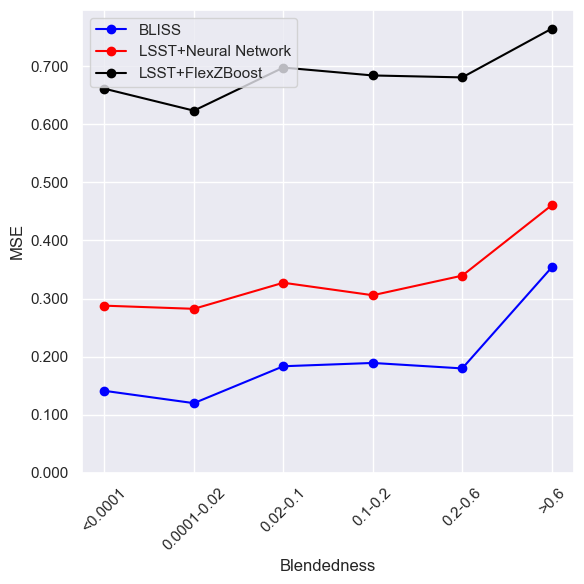

In [47]:
metrics = ['mse_blend_bin']
metric_labels = ['MSE']
sns.set_theme()
for i, metric in enumerate(metrics):
    blendedness_ranges = ['<0.0001', '0.0001-0.02', '0.02-0.1', '0.1-0.2', '0.2-0.6', '>0.6']
    bliss_values = [bliss_out_dict[f'redshifts/{metric}_{i}'] for i in range(len(blendedness_ranges))]
    lsst_values = [lsst_out_dict[f'redshifts/{metric}_{i}'] for i in range(len(blendedness_ranges))]
    lsst_flexzboost_values = lsst_flexzboost_df["mse"].values
    lsst_nn_values = lsst_nn_df["mse"].values
    plt.figure(figsize=(6, 6))
    plt.plot(blendedness_ranges, bliss_values, label="BLISS", marker='o', c="blue")
    plt.plot(blendedness_ranges, lsst_values, label="LSST+Neural Network", marker='o', c="red")
    # plt.plot(blendedness_ranges, lsst_nn_values, label="lsst+neural network", marker='o', c="purple")
    plt.plot(blendedness_ranges, lsst_flexzboost_values, label="LSST+FlexZBoost", marker='o', c="black")
    plt.xlabel('Blendedness')
    plt.xticks(rotation=45)
    plt.ylim([0, None])
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.ylabel(metric_labels[i])
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join("/home/qiaozhih/bliss/case_studies/redshift/evaluation/plot",f'3_lines_per_blendedness_range_sns_{metric}.pdf'))

### catastrophic outlier fraction optimization using bins